Stage 1

Search Radius 100 m

In [36]:
#Import Tools
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import openpyxl

In [37]:
# Gives adjacency dictionary (not mine)
edge_dict={}
def create_edge_dict(graph):
    for i, n in G.adjacency():
        # print("i is",i)
        # print("n is",n)
        edge_dict[i] = list(n)
    return edge_dict

# Gives duplicate items in a list (not mine)
def list_duplicates(seq):
  seen = set()
  seen_add = seen.add
  # adds all elements it doesn't know yet to seen and all other to seen_twice
  seen_twice = set( x for x in seq if x in seen or seen_add(x) )
  # turn the set into a list (as requested)
  return list( seen_twice )


#(https://www.geeksforgeeks.org/python-merge-two-lists-into-list-of-tuples/)
def merge(list1, list2):
      
    merged_list = []
    for i in range(max((len(list1), len(list2)))):
  
        while True:
            try:
                tup = (list1[i], list2[i])
            except IndexError:
                if len(list1) > len(list2):
                    list2.append('')
                    tup = (list1[i], list2[i])
                elif len(list1) < len(list2):
                    list1.append('')
                    tup = (list1[i], list2[i])
                continue
  
            merged_list.append(tup)
            break
    return merged_list


# function to check whether the list is empty or not
def is_list_empty(list):
    # checking the length
    if len(list) == 0:
        # returning true as length is 0
        return True
    # returning false as length is greater than 0
    return False

Stage 0 | Preperation of Data 

In [38]:
# Retrieve data regarding vacant spaces from excel file
from openpyxl import load_workbook
workbook = load_workbook(filename="Node_Information_TU.xlsx")
workbook.sheetnames
# worksheet for vacant spaces
sheet1 = workbook.worksheets[0]
# worksheet for waste sources
sheet2 = workbook.worksheets[1]

# Create dictionary based on excel worksheet
vacant_spaces={}
for value in sheet1.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        vacant_spaces[value[0]]={}
        vacant_spaces[value[0]]["location"]=value[1]
        vacant_spaces[value[0]]["tag"]=value[6]
        vacant_spaces[value[0]]["building"]=value[3]
        vacant_spaces[value[0]]["size_real"]=int(value[2])
        vacant_spaces[value[0]]["loc_building"]=value[4]
        vacant_spaces[value[0]]["orientation"]=value[5]
        vacant_spaces[value[0]]["node_type"]="vacant"

# Interpret Data
#Rules:
#structure (roof:1,ground:3,outside:3,basement:3,intermediate:2)
#solar (roof:3,
#       basement:1
#       ground & S,SW,SE:3,
#       ground $ E,W:2
#       ground $ N,NE,NW:1
#       outside & S,SW,SE:3,
#       outside $ E,W:2
#       outside $ N,NE,NW:1
#       intermediate & S,SW,SE:3,
#       intermediate & E,W:2
#       intermediate & N,NE,NW:1
#size (0-100 size:1)
#     (101-500 size:2)
#     (500-... size:3)

# Simplify vacant space characteristics
for space in vacant_spaces:
    if vacant_spaces[space]["loc_building"]=="roof":
        vacant_spaces[space]["structure"]=1
        vacant_spaces[space]["solar"]=3
    if vacant_spaces[space]["loc_building"]=="basement":
        vacant_spaces[space]["structure"]=3
        vacant_spaces[space]["solar"]=1
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=3

# Simplify vacant spaces' sizes based on predefined ranges
for space in vacant_spaces:
    if vacant_spaces[space]["size_real"]<=200:
        vacant_spaces[space]["size"]=1
    if (vacant_spaces[space]["size_real"]>200) and (vacant_spaces[space]["size_real"]<=1000) :
        vacant_spaces[space]["size"]=2
    if (vacant_spaces[space]["size_real"]>1000):
        vacant_spaces[space]["size"]=3
    
# Remove orientation,loc_building,size_real since these will not be used anymore
for space in vacant_spaces:
    vacant_spaces[space].pop("orientation")
    vacant_spaces[space].pop("size_real")
    vacant_spaces[space].pop("loc_building")   
     
# Retrieve waste sources
# Create dictionary based on excel worksheet
wastes={}
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            wastes[value[0]]={}
            wastes[value[0]]["location"]=value[1]
            wastes[value[0]]["tag"]=value[5]
            wastes[value[0]]["type"]=value[3]

In [39]:
# Retrieve connections between vacant spaces within radius=x
url1="https://raw.githubusercontent.com/erengozdeanil/Foodcycle/main/Edges_vacant100.txt"
resp1 = requests.get(url1)
edges1 = json.loads(resp1.text)
#converts nested lists into a list of tuples
nearby_space100  = [tuple(i) for i in edges1]

# Retrieve connections between vacant spaces and waste sources within radius=x with identifiers
url1="https://raw.githubusercontent.com/erengozdeanil/Foodcycle/main/Edges_try1.txt"
resp1 = requests.get(url1)
edges1 = json.loads(resp1.text)
#converts nested lists into a list of tuples
nearby_waste100 = [tuple(i) for i in edges1]

In [40]:
# In the excel sheet there were unnecessary/empty waste output points
# Remove empty points 
for waste in wastes:
    for couple in nearby_waste100:
        if wastes[waste]["type"]=="None":
            if waste in couple:
                print(couple, "removed")
                nearby_waste100.remove(couple)
                (couple,"removed")

('V2', 'WO15') removed
('V23', 'WO15') removed
('V75', 'WO15') removed
('V83', 'WO15') removed
('V28', 'WO16') removed
('V121', 'WO16') removed
('V138', 'WO16') removed
('V8', 'WO17') removed
('V13', 'WO17') removed
('V8', 'WO25') removed
('V79', 'WO25') removed
('V23', 'WO46') removed
('V130', 'WO46') removed
('V11', 'WO69') removed
('V19', 'WO69') removed
('V39', 'WO69') removed
('V50', 'WO69') removed
('V55', 'WO69') removed
('V65', 'WO69') removed
('V110', 'WO69') removed
('V29', 'WO70') removed
('V30', 'WO70') removed
('V38', 'WO70') removed
('V50', 'WO70') removed
('V55', 'WO70') removed
('V110', 'WO70') removed
('V16', 'WO71') removed
('V33', 'WO71') removed
('V48', 'WO71') removed
('V29', 'WO83') removed
('V38', 'WO83') removed
('V39', 'WO83') removed
('V50', 'WO83') removed
('V55', 'WO83') removed
('V57', 'WO83') removed
('V94', 'WO83') removed
('V99', 'WO83') removed


In [41]:
# Retrieve node information regarding waste sources
workbook = load_workbook(filename="Node_Information_TU.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]
wastes={}
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        if value[4]!=0:
            wastes[value[0]]={}
            wastes[value[0]]["location"]=value[1]
            wastes[value[0]]["source"]=value[2]
            wastes[value[0]]["tag"]=value[5]
            wastes[value[0]]["type"]=value[3]
            wastes[value[0]]["quantity"]=int(value[4])
            wastes[value[0]]["node_type"]="waste"


# Assign ranges to quantities
for waste in wastes:
    if wastes[waste]["type"]=="W1":
        if wastes[waste]["quantity"]<= 183705:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>183705) and (wastes[waste]["quantity"]<=918523):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>918523:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W2":
        if wastes[waste]["quantity"]<= 67500:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>67500) and (wastes[waste]["quantity"]<=337500):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>337500:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W3":
        if wastes[waste]["quantity"]<= 11813:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>11813) and (wastes[waste]["quantity"]<=59063):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>59063:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W4":
        if wastes[waste]["quantity"]<= 28200:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>28200) and (wastes[waste]["quantity"]<=141000):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>141000:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W5":
        if wastes[waste]["quantity"]<= 19342:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>19342) and (wastes[waste]["quantity"]<=96710):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>96710:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W6":
        if wastes[waste]["quantity"]<= 1560000:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>1560000) and (wastes[waste]["quantity"]<=7800000):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>7800000:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W7":
        if wastes[waste]["quantity"]<= 200000:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>200000) and (wastes[waste]["quantity"]<=1000000):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>1000000:
            wastes[waste]["size"]=3
            
# Remove real quantitis from the list since we will not use it again
for waste in wastes:
    wastes[waste].pop("quantity")

In [42]:
#Dictionary of urban farming systems
    # UF1: Vermiculture, UF2: Aquaculture, UF3: Mushroom, UF4: NFT, UF5: Medai Beds, UF6: Raised Beds, UF7: Water Culture, UF8: Plant Factory, UF9: Aeroponics
    # "S" : supplementary system, "F" : food production system
    # 3 : high, 2 : medium, 1 : low, 0 : none
uf_systems = {
"UF1":{"tag":"UF1","type":"S","weight":3,"solar":1,"in":["W1","W2","W3","W6"],"supplement":None,"out":["S4","S5"]},
"UF2":{"tag":"UF2","type":"SF","weight":3,"solar":2,"in":["W7"],"supplement":["S5"],"out":["O4","S2"]},
"UF3":{"tag":"UF3","type":"F","weight":2,"solar":1,"in":["W2","W3","W4","W6"],"supplement":None,"out":["O3","S4"]},
"UF4":{"tag":"UF4","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]},
"UF5":{"tag":"UF5","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","O2","W1"]},
"UF6":{"tag":"UF6","type":"F","weight":3,"solar":3,"in":["W6"],"supplement":["S4"],"out":["O1","O2","W1"]},
"UF7":{"tag":"UF7","type":"F","weight":3,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]},
"UF8":{"tag":"UF8","type":"F","weight":3,"solar":1,"in":["W5","W6"],"supplement":["S2"],"out":["O1","W1","W7"]},
"UF9":{"tag":"UF9","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]}
}

critical_items=["W1","W2","W3", "W4"]
non_critical_items=["W5","W6","W7"]

Stage 1 | Search Radius = 100 m

Data Processing

In [43]:
# Make a dictionary of vacant spaces and potential uf systems based on structural capacity & solar exposure
# Rule 1: Solar exposure of space == Solar exposure demand of system
#         Structural capacity of space >= Weight of space
#         Size of space == Quantity of waste

v_potential = {}
for k,v in vacant_spaces.items():
    uf_list=[]
    for j,y in uf_systems.items():
        if (vacant_spaces[k]["structure"])>=(uf_systems[j]["weight"]) and (vacant_spaces[k]["solar"])==(uf_systems[j]["solar"]) and (uf_systems[j]["type"]=="F"):
            v_potential[k]={}
            uf_list.append(uf_systems[j]["tag"])
            v_potential[k]["tag"]=vacant_spaces[k]["tag"]
            v_potential[k]["UF"]=uf_list

# Rule 2: If CO2, Heat and Rainwater are not in the same building as the vacant space, they cannot be used.
# Remove if vacant space is in a different building than the waste source (only for CO2, Heat and Rainwater)
for couple_count in range(len(nearby_waste100)):
    for couple in nearby_waste100:
        for index,item in enumerate(couple):
            if couple[1] in wastes:
                if vacant_spaces[couple[0]]["building"]!=wastes[couple[1]]["source"]:
                    print(couple,vacant_spaces[couple[0]]["building"],wastes[couple[1]]["source"],wastes[couple[1]]["type"])
                    if (wastes[couple[1]]["type"]=="W5") or (wastes[couple[1]]["type"]=="W6") or (wastes[couple[1]]["type"]=="W7"):
                        if couple in nearby_waste100:
                            print(couple,wastes[couple[1]]["type"])
                            print("removed",couple,wastes[couple[1]]["type"],vacant_spaces[couple[0]]["building"],wastes[couple[1]]["source"],wastes[couple[1]]["type"])
                            nearby_waste100.remove(couple)
            else:
                print(couple,"not in nearby_waste100")


('V0', 'WO74') outside AS2 W4
('V0', 'WO74') outside AS2 W4
('V0', 'WO77') outside fellowship W5
('V0', 'WO77') W5
removed ('V0', 'WO77') W5 outside fellowship W5
('V0', 'WO77') outside fellowship W5
('V1', 'WO27') outside AS W5
('V1', 'WO27') W5
removed ('V1', 'WO27') W5 outside AS W5
('V1', 'WO27') outside AS W5
('V1', 'WO26') outside AS W5
('V1', 'WO26') W5
removed ('V1', 'WO26') W5 outside AS W5
('V1', 'WO26') outside AS W5
('V2', 'WO38') 3me ID W5
('V2', 'WO38') W5
removed ('V2', 'WO38') W5 3me ID W5
('V2', 'WO38') 3me ID W5
('V2', 'WO39') 3me ID W5
('V2', 'WO39') W5
removed ('V2', 'WO39') W5 3me ID W5
('V2', 'WO39') 3me ID W5
('V5', 'WO53') outside EEMCS2 W3
('V5', 'WO53') outside EEMCS2 W3
('V5', 'WO52') outside EEMCS2 W5
('V5', 'WO52') W5
removed ('V5', 'WO52') W5 outside EEMCS2 W5
('V5', 'WO52') outside EEMCS2 W5
('V5', 'WO60') outside CEG W5
('V5', 'WO60') W5
removed ('V5', 'WO60') W5 outside CEG W5
('V5', 'WO60') outside CEG W5
('V5', 'WO66') outside CEG W3
('V5', 'WO66') ou

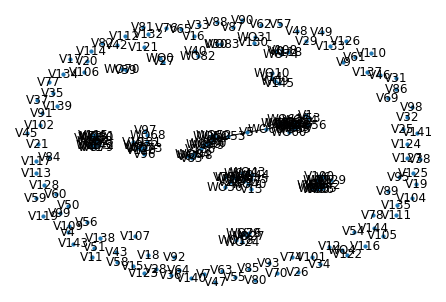

In [44]:
# Draw Graph with nodes and edges with coordinates
G=nx.Graph()
for i,j in vacant_spaces.items():
    G.add_node(i)
G.add_edges_from(nearby_waste100)
nx.draw(G, with_labels=True, node_size=10)

# Create a dictionary with vacant spaces and waste outputs them
new_waste_dict = create_edge_dict(G)
waste_dict = {}
for i,k in new_waste_dict.items():
    if i in vacant_spaces:
        waste_dict[i]=k
        
#List of dictionaries we will use:
# print(v_potential)
# print(waste_dict)
# print(uf_systems)

# Add needed inputs for each potential system into the v_potential dictionary
v_potential_dict={}
for i,k in v_potential.items():
    v_potential_dict[i]={}
    potential_systems = v_potential[i]["UF"]
    for item in potential_systems:
       v_potential_dict[i][item] = uf_systems[item]["in"]   

In [45]:
# Searching For Inputs
# Make a dictionary of found items nearby for each potential uf system
found_dict={}
for i,k in v_potential_dict.items():
    found_dict[i]={}
    for system,demanded in k.items():
        found_dict[i][system]={}
        found_dict[i][system]["found"]={}
        found_dict[i][system]["source"]={}
        found=[]
        source=[]
        for waste in waste_dict[i]:
            if waste in wastes:
                for each in demanded: 
                    available = wastes[waste]["type"]
                    source2 = wastes[waste]["tag"]
                    print(i,wastes[waste])
                    source_size = wastes[waste]["size"]
                    if each == available:
                        found.append(available)
                        source.append(source2)
                        found_dict[i][system]["found"]=found
                        found_dict[i][system]["source"]=source

V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'waste', 'size': 1}
V0 {'location': '{2065.234004, 423.253128, 0}', 'source': 'AS2', 'tag': 'WO74', 'type': 'W4', 'node_type': 'was

In [46]:
# Make a dictionary of missing items for each potential uf system           
for i,system in found_dict.items():
    for uf in system:
        missing=[]
        found_dict[i][uf]["missing"]={}
        for x,y in uf_systems.items():
            for item in uf_systems[x]["in"]:
                if uf == x:
                    missing.append(item)
                    found_dict[i][uf]["missing"]=missing
        
# In the dictionary missing items also contain found items
for i,k in found_dict.items():
    for system in k:
        for item in (found_dict[i][system]["found"]):
            if item in found_dict[i][system]["missing"]:
                missing_list=found_dict[i][system]["missing"]
                missing_list.remove(item)

# Reach sizes of duplicate items
for i,k in found_dict.items():
    for system in k:
        found_items=found_dict[i][system]["found"]


In [47]:
# Add a new list to the found dict -> for 1 waste source matching the size of space
# waste quantity == vacant space size
for space in found_dict:
    for system in found_dict[space]:
        found_dict[space][system]["enough waste"]=[]
        found_dict[space][system]["enough source"]=[]
        for item in found_dict[space][system]["source"]:
            if wastes[item]["size"]==vacant_spaces[space]["size"]:
                if found_dict[space][system]["enough waste"]==[]:
                    print(space,system,item,wastes[item]["type"],"1")
                    found_dict[space][system]["enough waste"].append(wastes[item]["type"])
                    found_dict[space][system]["enough source"].append(wastes[item]["tag"])
                    found_dict[space][system]["found"].remove(wastes[item]["type"])
                    found_dict[space][system]["source"].remove(wastes[item]["tag"])
                    break
                elif found_dict[space][system]["enough waste"]!=[]:
                    for waste in found_dict[space][system]["enough waste"]:
                        if wastes[waste]["type"]!=wastes[item]["type"]:
                            print(space,system,item,wastes[item]["type"],"2")
                            found_dict[space][system]["enough waste"].append(wastes[item]["type"])
                            found_dict[space][system]["enough source"].append(wastes[item]["tag"])
                            found_dict[space][system]["found"].remove(wastes[item]["type"])
                            found_dict[space][system]["source"].remove(wastes[item]["tag"])

V2 UF4 WO37 W6 1
V2 UF5 WO37 W6 1
V2 UF9 WO37 W6 1
V3 UF3 WO42 W6 1
V3 UF8 WO42 W6 1
V22 UF4 WO67 W6 1
V22 UF5 WO67 W6 1
V22 UF9 WO67 W6 1
V23 UF3 WO14 W3 1
V24 UF4 WO59 W6 1
V24 UF5 WO59 W6 1
V24 UF9 WO59 W6 1
V27 UF4 WO0 W7 1
V27 UF5 WO0 W7 1
V27 UF9 WO0 W7 1
V40 UF4 WO82 W7 1
V40 UF5 WO82 W7 1
V40 UF9 WO82 W7 1
V66 UF3 WO79 W3 1
V131 UF4 WO68 W5 1
V131 UF5 WO68 W5 1
V131 UF9 WO68 W5 1
V136 UF4 WO49 W5 1
V136 UF5 WO49 W5 1
V136 UF9 WO49 W5 1


In [48]:
# Make a dictionary holding each vacant space& found and repeating waste type & waste sources corresponding to found items
duplicate_items={}
for space,potential in found_dict.items():
    duplicate_items[space]={}
    for system, k in potential.items():
        if len(found_dict[space][system]["found"])> 1:
            found_items3=found_dict[space][system]["found"]
            sources=[]
            for index,items in enumerate(found_items3):
                duplicate_items[space][items]={}
                count=found_items3.count(items)
                if count>1:
                    items_str=str(items)
                    sources.append(found_dict[space][system]["source"][index])
                    duplicate_items[space][items]["matching sources"]=sources


In [49]:
# Check if the total size of found waste matches the vacant space size
# sum (waste quantity) == vacant space size 
satisfying_duplicate={}
not_enough_waste={}
for space, k in duplicate_items.items():
    print(space)
    satisfying_duplicate[space]={}
    not_enough_waste[space]={}
    for key,value in k.items():
        print(key)
        satisfying_duplicate[space][key]={}
        not_enough_waste[space][key]={}
        waste_matched=[]
        not_matched=[]
        if duplicate_items[space][key]!=[]:
            for m,n in duplicate_items[space][key].items():
                matched=duplicate_items[space][key][m]
                found_new=[]
                for items in matched:
                    found_new.append(items)
                    waste_matched.append(wastes[items]["size"])
                    if sum(waste_matched)==vacant_spaces[space]["size"]:
                        print(space,vacant_spaces[space]["size"], waste_matched, "add to found list and remove from missing")
                        print(found_new, "is found")
                        print(waste_matched)
                        satisfying_duplicate[space][key]=found_new
                        break
                    else:
                        # print(sum(waste_matched),"And",vacant_spaces[space]["size"],items)
                        not_matched.append(items)
                        print(not_matched,"is not matched")
                        not_enough_waste[space][key]=not_matched

V0
V1
V2
W5
['WO41'] is not matched
['WO41', 'WO43'] is not matched
V2 3 [1, 1, 1] add to found list and remove from missing
['WO41', 'WO43', 'WO44'] is found
[1, 1, 1]
V3
W2
W3
W5
['WO7'] is not matched
['WO7', 'WO5'] is not matched
V3 3 [1, 1, 1] add to found list and remove from missing
['WO7', 'WO5', 'WO8'] is found
[1, 1, 1]
V4
V6
V8
W5
['WO26'] is not matched
['WO26', 'WO24'] is not matched
V8 3 [1, 1, 1] add to found list and remove from missing
['WO26', 'WO24', 'WO27'] is found
[1, 1, 1]
V9
V10
V11
V12
V14
V15
V16
V17
V18
V19
V21
V22
W5
['WO58'] is not matched
['WO58', 'WO55'] is not matched
V22 3 [1, 1, 1] add to found list and remove from missing
['WO58', 'WO55', 'WO64'] is found
[1, 1, 1]
V23
V24
W5
['WO51'] is not matched
['WO51', 'WO50'] is not matched
V24 3 [1, 1, 1] add to found list and remove from missing
['WO51', 'WO50', 'WO52'] is found
[1, 1, 1]
V25
V26
V27
V28
V29
V30
V31
V32
V33
V35
V36
V37
V38
V39
V40
V41
W3
W4
V42
V43
V44
W5
['WO57'] is not matched
['WO57', 'WO5

In [50]:
# Remove duplicate items if they are also in satisfying_duplicate items list until there is only one of each waste type left
for space,potential in found_dict.items():
    for system in potential.keys():
        for key, value in satisfying_duplicate.items():
            for waste in value.keys():
                if key==space:
                        if len(found_dict[space][system]["found"])>0:
                            print("there are found items")
                            if len(satisfying_duplicate[key][waste])>0:
                                print("there are satisfying duplicate items")
                                if waste in found_dict[space][system]["found"]:
                                    print(waste,"is in found dict",space,system)
                                    found_items = found_dict[space][system]["found"]
                                    found_dict[space][system]["enough waste"].append(waste)
                                    for item in satisfying_duplicate[key][waste]:
                                        found_dict[space][system]["enough source"].append(item)
                                        found_dict[space][system]["source"].remove(item)
                                    for found_range in range(len(found_items)):
                                        for found in found_items:
                                            print(found_items,space,system)
                                            counter=found_items.count(found)
                                            print(waste,counter,space,system)
                                            if counter>1:
                                                print(found,"REMOVED",space,system)  
                                                found_items.remove(found)

there are found items
there are satisfying duplicate items
W5 is in found dict V2 UF4
['W5', 'W5', 'W5', 'W5'] V2 UF4
W5 4 V2 UF4
W5 REMOVED V2 UF4
['W5', 'W5', 'W5'] V2 UF4
W5 3 V2 UF4
W5 REMOVED V2 UF4
['W5', 'W5'] V2 UF4
W5 2 V2 UF4
W5 REMOVED V2 UF4
['W5'] V2 UF4
W5 1 V2 UF4
['W5'] V2 UF4
W5 1 V2 UF4
there are found items
there are satisfying duplicate items
W5 is in found dict V2 UF5
['W5', 'W5', 'W5', 'W5'] V2 UF5
W5 4 V2 UF5
W5 REMOVED V2 UF5
['W5', 'W5', 'W5'] V2 UF5
W5 3 V2 UF5
W5 REMOVED V2 UF5
['W5', 'W5'] V2 UF5
W5 2 V2 UF5
W5 REMOVED V2 UF5
['W5'] V2 UF5
W5 1 V2 UF5
['W5'] V2 UF5
W5 1 V2 UF5
there are found items
there are satisfying duplicate items
W5 is in found dict V2 UF9
['W5', 'W5', 'W5', 'W5'] V2 UF9
W5 4 V2 UF9
W5 REMOVED V2 UF9
['W5', 'W5', 'W5'] V2 UF9
W5 3 V2 UF9
W5 REMOVED V2 UF9
['W5', 'W5'] V2 UF9
W5 2 V2 UF9
W5 REMOVED V2 UF9
['W5'] V2 UF9
W5 1 V2 UF9
['W5'] V2 UF9
W5 1 V2 UF9
there are found items
there are found items
there are found items
there are satisf

In [51]:
# Remove duplicate items from "found list" if they are not in satisfying_duplicate items list
for space in found_dict.keys():
    for system in found_dict[space].keys():
        found_items = found_dict[space][system]["found"]
        missing_items = found_dict[space][system]["missing"]
        duplicate=list_duplicates(found_items)
        for key, value in satisfying_duplicate.items():
            for waste in value.keys():
                if key==space:
                    for found in found_items:
                        if found in duplicate:
                            print("duplicate",space,found,system)
                            if satisfying_duplicate[space][found]==[]:
                                print("duplicate not satisfying",space,found,system)
                                found_items.remove(found) 
                                if found not in missing_items:
                                    missing_items.append(found)
                                if (found in missing_items) and (found in found_items):
                                    found_items.remove(found)            
for space in found_dict:
    for system in found_dict[space]:
        source=found_dict[space][system]["source"]
        for index,item in enumerate(source):
            waste=wastes[item]["type"]
            if waste in found_dict[space][system]["found"]:
                print("found",space,item,waste)
            else:
                source.remove(item)
                print(item,"removed from",space,system,waste)

duplicate V52 W5 UF4
duplicate V52 W5 UF4
duplicate V52 W5 UF5
duplicate V52 W5 UF5
duplicate V52 W5 UF9
duplicate V52 W5 UF9
found V2 WO45 W5
found V2 WO45 W5
found V2 WO45 W5
found V3 WO1 W2
found V3 WO3 W3
found V3 WO6 W5
found V8 WO18 W5
found V8 WO18 W5
found V8 WO18 W5
found V22 WO61 W5
found V22 WO57 W5
found V22 WO63 W5
found V22 WO60 W5
found V22 WO62 W5
found V22 WO61 W5
found V22 WO57 W5
found V22 WO63 W5
found V22 WO60 W5
found V22 WO62 W5
found V22 WO61 W5
found V22 WO57 W5
found V22 WO63 W5
found V22 WO60 W5
found V22 WO62 W5
found V23 WO34 W3
found V24 WO49 W5
found V24 WO49 W5
found V24 WO49 W5
found V41 WO79 W3
found V41 WO78 W4
found V44 WO64 W5
found V44 WO58 W5
found V44 WO63 W5
found V44 WO64 W5
found V44 WO58 W5
found V44 WO63 W5
found V44 WO64 W5
found V44 WO58 W5
found V44 WO63 W5
found V52 WO80 W5
found V52 WO81 W5
found V52 WO80 W5
found V52 WO81 W5
found V52 WO80 W5
found V52 WO81 W5
found V66 WO78 W4
found V68 WO42 W6
found V68 WO5 W5
found V68 WO6 W5
found 

In [52]:
# Add symbiosis percentage to found_dict
for space in found_dict:
    for system in found_dict[space]:
        found_dict[space][system]["circularity"]=[]
        found=len(found_dict[space][system]["enough waste"])
        missing=len(found_dict[space][system]["missing"])
        total=found+missing
        found_dict[space][system]["circularity"]=found/total

# Make a copy of found dict, sort system based on circularities
sorted_dict={}
for space in found_dict:
    system=sorted(found_dict[space], key=lambda x: (found_dict[space][x]['circularity']), reverse=True)  
    sorted_dict[space]={} 
    for item in system:
        values={}
        values=(found_dict[space][item])
        sorted_dict[space][item]=values

Assign Food Production Systems

In [53]:
# Check if the criteria is satisfied
# Rule 3: Assign a system if there are at least 1 found item
# Rule 4: Assign a system if there is no missing items
# Rule 5: Assign a system if there is one missing item which is not critical
# Rule 6: Assign a system if there is two missing items which are not critical
# Rule 7: If a found waste source is already used, it cannot be used again
# Rule 8: If a critical item is missing, that system cannot be asigned
occupied={}
used_waste=[]
used_waste_source=[]
used_waste_source_temp=[]
new_edges=[]
occupied_dict={}

for space in sorted_dict:
    print("looking for", space)
    print("for",space,sorted_dict[space],"is possible")
    occupied_dict[space]={}
    occupied_dict[space]["system"]={}
    occupied_dict[space]["found"]={}
    occupied_dict[space]["source"]={}
    occupied_dict[space]["missing"]={}
    for index,system in enumerate(sorted_dict[space]):
        print("looking for system", system)
        occupied[space]={}
        occupied[space]["system"]={}
        found_list=sorted_dict[space][system]["enough waste"]
        sources_list=sorted_dict[space][system]["enough source"]
        missing_list=sorted_dict[space][system]["missing"]
        print(len(missing_list),"is length for",space,system)

        if len(occupied[space]["system"])==0:
            print(space,"is not occupied run for",system)
            if len(missing_list)==0:    
                for source in sources_list:
                    if source in used_waste_source:
                        print(used_waste_source,"is used",space,system)
                        pass
                    elif source not in used_waste_source:
                        print(used_waste_source,"is used",space,system)
                        occupied[space]["system"]=system
                        occupied_dict[space]["system"]=system
                        occupied_dict[space]["found"]=sorted_dict[space][system]["enough waste"]
                        occupied_dict[space]["source"]=sorted_dict[space][system]["enough source"]
                        for items in found_list:
                            used_waste.append(items)
                        used_waste_source.append(source)
                        edge_tuple=(source,space)
                        new_edges.append(edge_tuple)
                        print("no missing items:", space, system, "assign")
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break
            elif len(missing_list)==1:
                print("one item",system,space)
                for missing in missing_list:
                    if missing in non_critical_items:
                        print("one non critical item",missing,system,space)
                        for source in sources_list:
                            if source not in used_waste_source:
                                print("Used Non Critical Source",source)
                                occupied[space]["system"]=system
                                occupied_dict[space]["system"]=system
                                occupied_dict[space]["found"]=sorted_dict[space][system]["enough waste"]
                                occupied_dict[space]["source"]=sorted_dict[space][system]["enough source"]
                                occupied_dict[space]["missing"]=sorted_dict[space][system]["missing"]
                                for items in found_list:
                                    used_waste.append(items)
                                used_waste_source.append(source)
                                edge_tuple=(source,space)
                                new_edges.append(edge_tuple)
                                print("one non critical missing items:", space, system, "assign")
                            else:
                                print(source,"already used")
                    else:
                        print(space,"critical item missing:",missing,"for",system)
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break 
            elif len(missing_list)==2:
                print("two items",system,space)
                for missing in missing_list:
                    print("two items",missing)
                    if missing in non_critical_items:
                        print("two items",missing,"not critical")
                        for source in sources_list:
                            if source not in used_waste_source:
                                print("Used Non Critical Source",source)
                                occupied[space]["system"]=system
                                occupied_dict[space]["system"]=system
                                occupied_dict[space]["found"]=sorted_dict[space][system]["enough waste"]
                                occupied_dict[space]["source"]=sorted_dict[space][system]["enough source"]
                                occupied_dict[space]["missing"]=sorted_dict[space][system]["missing"]
                                for items in found_list:
                                    used_waste.append(items)
                                print("two non critical missing items:", space, system,"assign")
                                print(space,occupied_dict[space])
                                used_waste_source.append(source)
                                edge_tuple=(source,space)
                                new_edges.append(edge_tuple)
                    else:
                        print(space,"critical item missing:",missing,"for",system)
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break  

looking for V0
for V0 {'UF4': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'enough waste': [], 'enough source': [], 'circularity': 0.0}, 'UF5': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'enough waste': [], 'enough source': [], 'circularity': 0.0}, 'UF6': {'found': {}, 'source': {}, 'missing': ['W6'], 'enough waste': [], 'enough source': [], 'circularity': 0.0}, 'UF7': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'enough waste': [], 'enough source': [], 'circularity': 0.0}, 'UF9': {'found': {}, 'source': {}, 'missing': ['W5', 'W6', 'W7'], 'enough waste': [], 'enough source': [], 'circularity': 0.0}} is possible
looking for system UF4
3 is length for V0 UF4
V0 is not occupied run for UF4
looking for system UF5
3 is length for V0 UF5
V0 is not occupied run for UF5
looking for system UF6
1 is length for V0 UF6
V0 is not occupied run for UF6
one item UF6 V0
one non critical item W6 UF6 V0
looking for system UF7
3 is length for V0 UF7
V0 is not oc

Create New List To Be Used In Next Steps

In [54]:
# Add circularity & outputs to occupied_dict
for space in occupied_dict:
    occupied_dict[space]["circularity"]={}
    occupied_dict[space]["outputs"]={}
    occupied_dict[space]["supplements"]={}
    if len(occupied_dict[space]["system"])!=0:
        system=occupied_dict[space]["system"]
        outputs=(uf_systems[system]["out"])
        supplements=uf_systems[system]["supplement"]
        occupied_dict[space]["circularity"]=sorted_dict[space][system]["circularity"]
        occupied_dict[space]["supplements"]=supplements
        occupied_dict[space]["outputs"]=outputs

# Remove empty spaces from occupied_dict
remove=[]
for space in occupied_dict:
    if len(occupied_dict[space]["system"])==0:
        remove.append(space)
for items in remove:
    occupied_dict.pop(items)

# Remove occupied spaces from found_dict
remove2=[]
for space in sorted_dict:
    if space in occupied_dict:
        remove2.append(space)
for items in remove2:
    sorted_dict.pop(items)

Assign Food Producing Supplementary Systems

Prepare Data

In [55]:
# Look for a system that can supply needed supplement ("S2" = nutrient dense water)
# Put the findings in a dictionary
v_supplement_fs={}
for space in occupied_dict:
    v_supplement_fs[space]={}
    v_supplement_fs[space]["supplement"]={}
    v_supplement_fs[space]["fs_system"]={}
    v_supplement_fs[space]["supplement"]={}
    v_supplement_fs[space]["supplement source"]={}
    v_supplement_fs[space]["fs_demand"]={}
    v_supplement_fs[space]["fs_demand source"]={}
    v_supplement_fs[space]["potential source"]={}
    supplement=occupied_dict[space]["supplements"]
    if supplement!=None:
        for item in supplement:
            if item=="S2": 
                for i in uf_systems:
                    out=uf_systems[i]["out"]
                    if "S2" in out:
                        print("maybe",space, i,uf_systems[i]["in"])
                        v_supplement_fs[space]["fs_system"]=i
                        v_supplement_fs[space]["supplement"]=item
                        v_supplement_fs[space]["fs_demand"]=uf_systems[i]["in"]
    else:
        v_supplement_fs[space]["fs_system"]={}

maybe V2 UF2 ['W7']
maybe V3 UF2 ['W7']
maybe V8 UF2 ['W7']
maybe V22 UF2 ['W7']
maybe V24 UF2 ['W7']
maybe V27 UF2 ['W7']
maybe V40 UF2 ['W7']
maybe V44 UF2 ['W7']
maybe V72 UF2 ['W7']
maybe V131 UF2 ['W7']
maybe V136 UF2 ['W7']


In [56]:
# We created a dictionary for spaces which need supplement to store system, supplementing neighbor and supplement type for each space found what kind of system and supplement and input is necessary 
# Check the neighbors of supplement needing space to see if there is a potential neighbor with the same size, enough structural capacity and same solar exosure
# Rule 8: (supplement needing space's size) == (its neighbors size)
# Rule 9: (neighbor's solar exposure) == (needed system's solar exposure)
# Rule 10: (neighbor's structural capacity) >= (needed system's weight)
for space in v_supplement_fs:
    potential=[]
    for space2,neighbor in nearby_space100:
        if space==space2:
            if v_supplement_fs[space]["fs_system"]!=None:
                if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                    system=v_supplement_fs[space]["fs_system"]
                    print(system,"system")
                    print(vacant_spaces[space]["size"],vacant_spaces[neighbor]["size"])
                    if (vacant_spaces[space]["size"]==vacant_spaces[neighbor]["size"]) and (vacant_spaces[neighbor]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[neighbor]["solar"]>=uf_systems[system]["solar"]):
                        potential.append(neighbor)
                        v_supplement_fs[space]["potential source"]=potential
        elif space==neighbor:
                print(neighbor,space2,"reverse is available")
                if v_supplement_fs[space]["fs_system"]!=None:
                    if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                        print(space2,"is available")
                        system=v_supplement_fs[space]["fs_system"]
                        if (vacant_spaces[space]["size"]==vacant_spaces[space2]["size"]) and (vacant_spaces[space2]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[space2]["solar"]>=uf_systems[system]["solar"]):
                            potential.append(space2)
                            print(potential)
                            print(space,potential)
                            print(space,"matches",space2,"and",system)
                            v_supplement_fs[space]["potential source"]=potential
                        else:
                            print("structure",space,vacant_spaces[space2]["structure"],system,uf_systems[system]["weight"])
                            print("sun",space,vacant_spaces[space2]["solar"],system,uf_systems[system]["solar"])
                    else:
                        print(space,space2,"not available",v_supplement_fs[space]["fs_system"],"no need for supplement")

UF2 system
3 3
UF2 system
3 3
V2 V13 reverse is available
V13 is available
['V13', 'V13']
V2 ['V13', 'V13']
V2 matches V13 and UF2
V2 V23 reverse is available
V23 is available
structure V2 3 UF2 3
sun V2 1 UF2 2
UF2 system
3 2
UF2 system
3 2
V3 V68 reverse is available
V68 is available
structure V3 2 UF2 3
sun V3 3 UF2 2
V3 V100 reverse is available
V100 is available
structure V3 3 UF2 3
sun V3 3 UF2 2
UF2 system
3 2
UF2 system
3 3
V8 V25 reverse is available
V25 is available
structure V8 1 UF2 3
sun V8 3 UF2 2
V8 V79 reverse is available
V79 is available
structure V8 1 UF2 3
sun V8 3 UF2 2
UF2 system
3 3
V22 V44 reverse is available
V44 is available
structure V22 1 UF2 3
sun V22 3 UF2 2
V24 V5 reverse is available
V5 is available
['V5']
V24 ['V5']
V24 matches V5 and UF2
UF2 system
3 3
UF2 system
3 2
UF2 system
3 1
V24 V94 reverse is available
V94 is available
structure V24 1 UF2 3
sun V24 3 UF2 2
V24 V136 reverse is available
V136 is available
structure V24 1 UF2 3
sun V24 3 UF2 2
UF2

In [57]:
# Check if potential sources have necessary waste sources nearby
# Rule 11: For food producing supplementary systems all the items should be found
for space in v_supplement_fs:
    potential=v_supplement_fs[space]["potential source"]
    if len(v_supplement_fs[space]["supplement source"])==0:
        for vacant in potential:
            nearby_list=waste_dict[vacant]
            print(nearby_list)
            for nearby in nearby_list:
                print(vacant, nearby,"is",wastes[nearby]["type"])
                if nearby not in used_waste_source:
                    if wastes[nearby]["size"]==vacant_spaces[space]["size"]:
                        print(nearby,"not used")
                        if v_supplement_fs[space]["fs_demand"]==wastes[nearby]["type"]:
                            print("for",space,vacant,"is potential and has",nearby,"as a source of",wastes[nearby]["type"])
                            v_supplement_fs[space]["supplement source"]=vacant
                            print(v_supplement_fs[space]["supplement source"])
                            v_supplement_fs[space]["fs_demand source"]=nearby
                            print(v_supplement_fs[space]["fs_demand source"])
                            used_waste_source.append(nearby)
                            edge_tuple1=(nearby,vacant)
                            edge_tuple2=(vacant,space)
                            new_edges.append(edge_tuple1)
                            new_edges.append(edge_tuple2)
                            if len(v_supplement_fs[space]["supplement source"])>0:      
                                break
                        elif v_supplement_fs[space]["fs_demand"]!=wastes[nearby]["type"]:
                            print(v_supplement_fs[space]["fs_demand"],wastes[nearby]["type"])
                            v_supplement_fs[space]["supplement source"]=vacant
                            print(v_supplement_fs[space]["supplement source"])
                            v_supplement_fs[space]["fs_demand source"]="supply externally"
                            print(v_supplement_fs[space]["fs_demand source"])
                            edge_tuple2=(vacant,space)
                            print(vacant,space)
                            new_edges.append(edge_tuple2)
                            if len(v_supplement_fs[space]["supplement source"])>0:   
                                break

            if len(v_supplement_fs[space]["supplement source"])>0:     
                            break

['WO40']
V13 WO40 is W4
['WO40']
V13 WO40 is W4
['WO53', 'WO66']
V5 WO53 is W3
V5 WO66 is W3
WO66 not used
['W7'] W3
V5
supply externally
V5 V24
['WO54']
V53 WO54 is W1
['WO54']
V53 WO54 is W1
['WO54']
V1 WO54 is W1
['WO54']
V1 WO54 is W1


In [58]:
# Add newly assigned food-producing supplementary systems to the "occupied nodes" list
for space in v_supplement_fs:
    if len(v_supplement_fs[space]["fs_system"])!=0:
        if (len(v_supplement_fs[space]["supplement source"])!=0) and (v_supplement_fs[space]["fs_demand source"]!="supply externally"):
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            system=occupied_dict[occ]["system"]
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
            occupied_dict[occ]["supplements"]=uf_systems[system]["supplement"]
            occupied_dict[occ]["circularity"]=1
        elif v_supplement_fs[space]["fs_demand source"]=="supply externally":
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            occupied_dict[occ]["found"]=None
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            system=occupied_dict[occ]["system"]
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
            occupied_dict[occ]["supplements"]=uf_systems[system]["supplement"]
            occupied_dict[occ]["circularity"]=0

In [59]:
#   Make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["found"]

# Make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["found"]

Assigning Supplementary Systems

In [60]:

# Now we have food supplying supplementary systems
# We still need to check if these systems need supplements ("S4" fish food or "S5" fertiliser)
for space in occupied_dict: 
    system=occupied_dict[space]["system"]
    value=uf_systems[system]["supplement"]
    if value!=None:
        for supplement in value:
            if (supplement=="S5") or (supplement=="S4"):
                v_supplement_fs[space]={}
                v_supplement_fs[space]["supplement"]=supplement
                for uf in uf_systems:
                    for out in uf_systems[uf]["out"]:
                        if supplement == out:
                            v_supplement_fs[space]["fs_system"]=uf
                            v_supplement_fs[space]["fs_demand"]=uf_systems[uf]["in"]
                v_supplement_fs[space]["supplement source"]={}
                v_supplement_fs[space]["fs_demand source"]={}
                v_supplement_fs[space]["potential source"]={}

In [61]:
# Make a potential list of vacant spaces around the supplement needing space
# Rule 12: (supplement needing space's size) == (its neighbors size)
# Rule 13: (neighbor's solar exposure) == (needed system's solar exposure)
# Rule 14: (neighbor's structural capacity) >= (needed system's weight)
for space in v_supplement_fs:
    potential=[]
    for space2,neighbor in nearby_space100:  
        if (space==space2):
            if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                system=v_supplement_fs[space]["fs_system"]
                if (vacant_spaces[space]["size"]==vacant_spaces[neighbor]["size"]) and (vacant_spaces[neighbor]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[neighbor]["solar"]>=uf_systems[system]["solar"]):
                    potential.append(neighbor)
                    v_supplement_fs[space]["potential source"]=potential
                else:
                    print(space,vacant_spaces[neighbor]["structure"],system,uf_systems[system]["weight"])
            else:
                print(space,neighbor,"not available",v_supplement_fs[space]["fs_system"],"no need for supplement")
        elif space==neighbor:
            if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                print(space2,"is available")
                system=v_supplement_fs[space]["fs_system"]
                if (vacant_spaces[space]["size"]==vacant_spaces[space2]["size"]) and (vacant_spaces[space2]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[space2]["solar"]>=uf_systems[system]["solar"]):
                    potential.append(space2)
                    v_supplement_fs[space]["potential source"]=potential
                else:
                    print("structure",space,vacant_spaces[space2]["structure"],system,uf_systems[system]["weight"])
                    print("sun",space,vacant_spaces[space2]["solar"],system,uf_systems[system]["solar"])
                    print("size",vacant_spaces[space]["size"]==vacant_spaces[space2]["size"])
            else:
                print(space,space2,"not available",v_supplement_fs[space]["fs_system"],"no need for supplement")

V2 3 UF2 3
V13 is available
V23 is available
structure V2 3 UF2 3
sun V2 1 UF2 2
size True
V3 2 UF2 3
V3 3 UF2 3
V68 is available
structure V3 2 UF2 3
sun V3 3 UF2 2
size False
V100 is available
structure V3 3 UF2 3
sun V3 3 UF2 2
size False
V8 1 UF2 3
V8 1 UF2 3
V25 is available
structure V8 1 UF2 3
sun V8 3 UF2 2
size True
V79 is available
structure V8 1 UF2 3
sun V8 3 UF2 2
size False
V22 1 UF2 3
V44 is available
structure V22 1 UF2 3
sun V22 3 UF2 2
size True
V24 V5 not available UF2 no need for supplement
V24 V5 not available UF2 no need for supplement
V24 V94 not available UF2 no need for supplement
V24 V136 not available UF2 no need for supplement
V24 V94 not available UF2 no need for supplement
V24 V136 not available UF2 no need for supplement
V27 3 UF2 3
V27 3 UF2 3
V27 3 UF2 3
V27 3 UF2 3
V27 3 UF2 3
V27 3 UF2 3
V53 is available
V98 is available
structure V27 3 UF2 3
sun V27 2 UF2 2
size False
V119 is available
structure V27 3 UF2 3
sun V27 2 UF2 2
size False
V124 is availabl

In [62]:
# Check if potential sources have necessary waste sources around
# Rule 15: For supplementary systems all the items should be found
for space in v_supplement_fs:
    potential=v_supplement_fs[space]["potential source"]
    if len(v_supplement_fs[space]["supplement source"])==0:
        for vacant in potential:
            found=[]
            found_source=[]
            nearby_list=waste_dict[vacant]
            for nearby in nearby_list:
                if nearby not in used_waste_source:
                    if wastes[nearby]["size"]==vacant_spaces[space]["size"]:
                        found.append(wastes[nearby]["type"])
                        found_source.append(nearby)
                        if v_supplement_fs[space]["fs_demand"]==found:
                            v_supplement_fs[space]["supplement source"]=vacant
                            v_supplement_fs[space]["fs_demand source"]=found_source
                            for x in found_source:
                                used_waste_source.append(x)
                                edge_tuple1=(x,vacant)
                                new_edges.append(edge_tuple1)
                            edge_tuple2=(vacant,space)
                            new_edges.append(edge_tuple2)
                            if len(v_supplement_fs[space]["supplement source"])>0:
                                # print(space,system,"will break")        
                                break
            if len(v_supplement_fs[space]["supplement source"])>0:
                            # print(space,system,"will break2")        
                            break

In [63]:
# Add newly assigned supplementary systems to the "occupied nodes" list
for space in v_supplement_fs:
    occupied_dict[occ]["outputs"]={}
    if len(v_supplement_fs[space]["fs_system"])!=0:
        if (len(v_supplement_fs[space]["supplement source"])!=0):
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            system=v_supplement_fs[space]["fs_system"]
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
            occupied_dict[occ]["outputs"]=v_supplement_fs[space]["supplement"]
            occupied_dict[occ]["supplements"]=uf_systems[system]["supplement"]
            occupied_dict[occ]["circularity"]=1

In [64]:
# Make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["outputs"]
    
# print(network_dict)

for space in occupied_dict:
    if occupied_dict[space]["system"]==None:
        occupied_dict.remove(space)

Preparation For Increasing The Search Radius

In [65]:
# Export still vacant spaces, list of used waste sources, list of still available waste sources to be used in next stage after increasing search radius
vacant_spaces2=vacant_spaces.copy()

for space in occupied_dict:
    vacant_spaces2.pop(space)

file = "vacant spaces_bigger radius.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(vacant_spaces2, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")


wastes2={}

for waste in wastes:
    if waste not in used_waste_source:
        wastes2[waste]={}
        wastes2[waste]["location"]=wastes[waste]["location"]
        wastes2[waste]["source"]=wastes[waste]["source"]
        wastes2[waste]["tag"]=wastes[waste]["tag"]
        wastes2[waste]["type"]=wastes[waste]["type"]
        wastes2[waste]["size"]=wastes[waste]["size"]
        wastes2[waste]["node_type"]=wastes[waste]["node_type"]

file = "available waste 2.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(wastes2, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

file = "used waste.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(used_waste_source, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

vacant spaces_bigger radius.txt has been updated successfully
available waste 2.txt has been updated successfully
used waste.txt has been updated successfully


Data Preparation For Visualisation

In [66]:
# Combine wastes and vacant_spaces
workbook = load_workbook(filename="coordintes_xyz.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]

new_edges2=[]
for space in network_dict:
    sources=(network_dict[space]["receiver"])
    tuples=(space,sources)
    new_edges2.append(tuples)

In [67]:
# Update locations in dictionary based on excel worksheet
# This step needs to be done because the type of data for coordinates is "string" in the excel sheets
# "strings" cannot be read in grasshopper as coordinates
coordinate_list1=[]
for value in sheet1.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            coordinate=(value[0],value[1],value[2])
    coordinate_list1.append(coordinate)

for index1,space in enumerate(vacant_spaces):
    for index2,coordinate in enumerate(coordinate_list1):
        if index1==index2:
            vacant_spaces[space]["location"]=coordinate_list1[index2]

workbook = load_workbook(filename="Node_Information_TU.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]
wastes2={}
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        wastes2[value[0]]={}
        wastes2[value[0]]["location"]=value[1]
        wastes2[value[0]]["source"]=value[2]
        wastes2[value[0]]["type"]=value[3]
        wastes2[value[0]]["quantity"]=value[4]
        wastes2[value[0]]["tag"]=value[5]
        wastes2[value[0]]["node_type"]="waste"

workbook = load_workbook(filename="coordintes_xyz.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]

# Construct coordinates from x,y,z values
coordinate_list2=[]
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            coordinate=(value[0],value[1],value[2])
    coordinate_list2.append(coordinate)

for index1,space in enumerate(wastes2):
    for index2,coordinate in enumerate(coordinate_list2): 
        if index1==index2:
            # print(index2,coordinate,space)
            wastes2[space]["location"]=coordinate_list2[index2]

combined_dict=vacant_spaces.copy()
combined_dict.update(wastes2)

coordinates=[]
# Make a coordinate list for new_edges [(coordinates1,coordinates2),(coordinates1,coordinates2),(coordinates1,coordinates2)]
for item in new_edges2:
        # print(item)
        coordinate_tuple=(combined_dict[item[0]]["location"],combined_dict[item[1]]["location"])
        print(item,coordinate_tuple)
        coordinates.append(coordinate_tuple)

('WO37', 'V2') ((758.520502, 435.418358, 0), (766.997201, 400.341737, 0))
('WO41', 'V2') ((771.944204, 401.859102, 0), (766.997201, 400.341737, 0))
('WO43', 'V2') ((771.944204, 375.850679, 0), (766.997201, 400.341737, 0))
('WO44', 'V2') ((771.944204, 354.876145, 0), (766.997201, 400.341737, 0))
('WO42', 'V3') ((246.741859, 572.172323, 0), (254.491041, 556.132177, 0))
('WO7', 'V3') ((207.729225, 560.007093, 0), (254.491041, 556.132177, 0))
('WO5', 'V3') ((253.034219, 609.506994, 0), (254.491041, 556.132177, 0))
('WO8', 'V3') ((289.9494, 507.990247, 0), (254.491041, 556.132177, 0))
('WO26', 'V8') ((857.520305, 565.460472, 0), (826.49752, 584.987928, 0))
('WO24', 'V8') ((788.723832, 565.460472, 0), (826.49752, 584.987928, 0))
('WO27', 'V8') ((886.045672, 565.460472, 0), (826.49752, 584.987928, 0))
('WO67', 'V22') ((1106.697775, 641.807777, 0), (1102.010609, 565.395898, 0))
('WO58', 'V22') ((1105.858794, 575.528248, 0), (1102.010609, 565.395898, 0))
('WO55', 'V22') ((1068.524122, 570.07486

In [68]:
# Make a dictionary of waste exchanges (start point, end point, waste type)
export_edges_dict={}
for index,couple in enumerate(coordinates):
        export_edges_dict[index]={}
        export_edges_dict[index]["coordinate"]=couple

export_edges_dict={}
for index,waste in enumerate(network_dict):
        export_edges_dict[index]={}
        export_edges_dict[index]["type"]=network_dict[waste]["type"]
        export_edges_dict[index]["connection"]=coordinates[index]

In [69]:
# Make a dictionary of all spaces, systems, coordinates, symbiotic rates
export_dict={}
for space in vacant_spaces:
    export_dict[space]={}
    export_dict[space]["location"]={}
    export_dict[space]["system"]={}
for space in vacant_spaces:
    if space in occupied_dict:
        export_dict[space]["system"]=occupied_dict[space]["system"]
        export_dict[space]["location"]=combined_dict[space]["location"]
        export_dict[space]["circularity"]=occupied_dict[space]["circularity"]
    else:
        export_dict[space]["system"]=None
        export_dict[space]["location"]=None

Export Decisions

In [70]:
# Export occupied nodes and connections to be visualised in Grasshopper
file = "occupied nodes.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(export_dict, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

file = "new_edges.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(new_edges, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

file = "new_edges_dict.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(export_edges_dict, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")        

file = "coordinates.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(coordinates, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

occupied nodes.txt has been updated successfully
new_edges.txt has been updated successfully
new_edges_dict.txt has been updated successfully
coordinates.txt has been updated successfully


8. INCREASING RADIUS